## One-Way ANOVA with OLS
This compares the means of three or more groups based on one factor.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import sys

# Create a dictionary of versions
versions = {
    "Python": sys.version.split()[0],
    "Pandas": pd.__version__,
    "Numpy": np.__version__,
    "Matplotlib": plt.matplotlib.__version__,
    "Seaborn": sns.__version__,
    "Statsmodels": sm.__version__,
    "Scipy": scipy.__version__,
    "Pingouin": pg.__version__
}
# Display as a clean DataFrame
df_versions = pd.DataFrame(list(versions.items()), columns=['Library', 'Version'])
df_versions

,Library,Version
0,Python,3.13.9
1,Pandas,2.3.3
2,Numpy,2.3.4
3,Matplotlib,3.10.7
4,Seaborn,0.13.2
5,Statsmodels,0.14.5
6,Scipy,1.16.3
7,Pingouin,0.5.5


## Generate Sample Data

In [2]:
# Simulate crime data: 3 neighborhood types (urban, suburban, rural), n=100 each
np.random.seed(1776)
urban = np.random.normal(45, 5, 100)      # High crime
suburban = np.random.normal(20, 4, 100)   # Medium
rural = np.random.normal(5, 2, 100)       # Low

df = pd.DataFrame({
    'burglaries': np.concatenate([urban, suburban, rural]),
    'neighborhood': np.repeat(['urban', 'suburban', 'rural'], 100)
})

df.head()

,burglaries,neighborhood
0,45.059813,urban
1,39.207040,urban
2,48.228861,urban
3,38.516195,urban
4,44.272430,urban


In [3]:
df.groupby('neighborhood').burglaries.mean()

neighborhood
rural        5.045887
suburban    19.637277
urban       44.700864
Name: burglaries, dtype: float64

### Normality Check

In [4]:
# Using Pingouin to check
normality = pg.normality(data=df, dv='burglaries', group='neighborhood')
normality

,W,pval,normal
neighborhood,,,
urban,0.991969,0.818999,True
suburban,0.987801,0.493632,True
rural,0.992402,0.849560,True


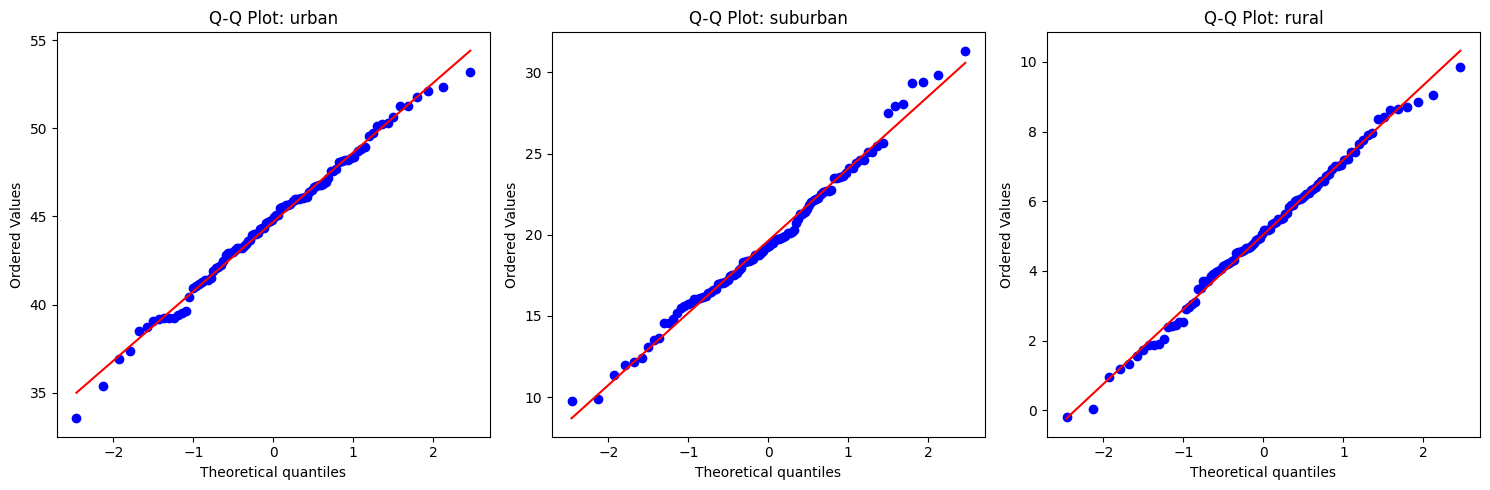

In [5]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
groups = df['neighborhood'].unique()

for i, area in enumerate(groups):
    stats.probplot(df[df['neighborhood'] == area]['burglaries'], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {area}')

plt.tight_layout()
plt.show()

### Homogeneity of variances - Levene's test

In [6]:
pg.homoscedasticity(df, dv='burglaries', group='neighborhood')

,W,pval,equal_var
levene,17.16964,8.786251e-08,False


The data fails the homogeneity of variance test (meaning Levene’s test returns $p < 0.05$, and equal_var is False), and the standard ANOVA becomes unreliable. This is because a traditional ANOVA assumes that the "spread" or "noise" is consistent across all groups. If we proceed with a standard ANOVA when variances are unequal, we risk a **Type I Error** (finding a "significant" result that isn't actually there).

Instead of the standard ANOVA, use Welch’s ANOVA. It does not assume equal variances. It applies a mathematical adjustment to the Degrees of Freedom ($df$) to yield a more accurate $p-value$.

### 🛠️ Visualizing the Failure

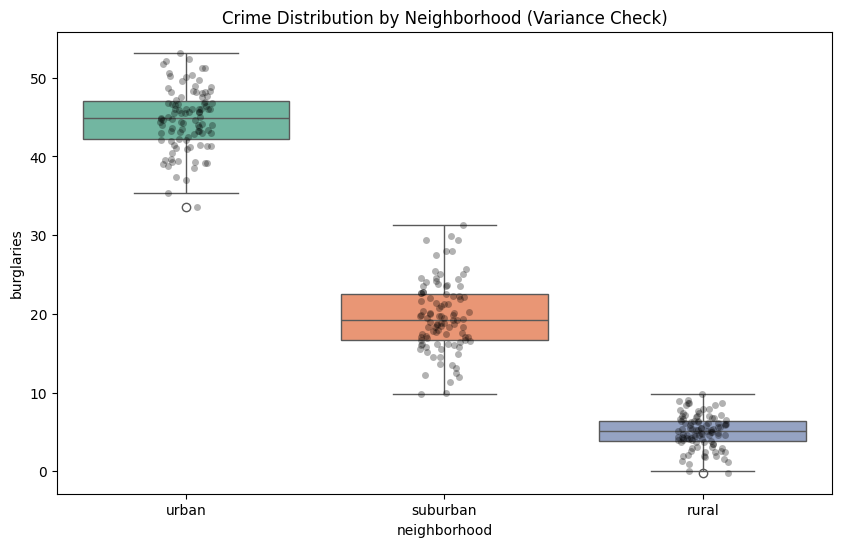

In [7]:
plt.figure(figsize=(10, 6))

# Updated syntax: assign x to hue and disable the redundant legend
sns.boxplot(
    data=df, 
    x='neighborhood', 
    y='burglaries', 
    hue='neighborhood', 
    palette='Set2', 
    legend=False
)
sns.stripplot(data=df, x='neighborhood', y='burglaries', color='black', alpha=0.3)
plt.title('Crime Distribution by Neighborhood (Variance Check)')
plt.show()

### One-Way ANOVA with OLS

In [8]:
# OLS HC3 allows you to see the individual adjusted t-stats for each group
model_hc3 = ols('burglaries ~ C(neighborhood)', data=df).fit(cov_type='HC3')
print(model_hc3.summary())

# Perform ANOVA
# typ=2 is standard for balanced designs; use typ=3 for unbalanced data
anova_table = sm.stats.anova_lm(model_hc3, type=2)

# print
print("\nANOVA Table")
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:             burglaries   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     4033.
Date:                Fri, 26 Dec 2025   Prob (F-statistic):          5.45e-216
Time:                        17:16:42   Log-Likelihood:                -808.89
No. Observations:                 300   AIC:                             1624.
Df Residuals:                     297   BIC:                             1635.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The model shows a strong relationship between neighborhood type and burglary rates. With an `R-squared of 0.954`, 95.4% of the variation in your data is explained simply by which neighborhood the data point belongs to.

1. The Group Means
    - Because this is a categorical OLS model, the coefficients tell the predicted averages for each group:
        - Reference Group (likely "Rural"): Average of 5.05 burglaries.
        - Suburban: Average of 19.64 burglaries ($5.05 + 14.59$).
        - Urban: Average of 44.70 burglaries ($5.05 + 39.65$).
    - The $P$-values for both coefficients are $0.000$ (well below the $\alpha = 0.05$ threshold), meaning the differences between these groups and the reference group are highly significant.
2. Residual Diagnostics
    - While the model is strong, the diagnostic tests suggest a few things to watch out for:
        - Jarque-Bera ($5.969, p=0.0506$): This is right on the edge of significance. If $p < 0.05$, we would reject the assumption that your residuals are normally distributed. Since it's $0.0506$, your residuals are barely normal. This is common in "count" data like burglaries, which often follow a Poisson or Negative Binomial distribution rather than a normal one.
        - Kurtosis ($3.677$): A normal distribution has a kurtosis of 3. Your value is slightly higher, meaning you have "fatter tails" (a few more outliers than expected).
3. Interpreting the ANOVA Table
- The ANOVA table provides the "Global Test." It asks: Does neighborhood matter at all?
    - F-statistic (3094.96): This is massive. It confirms that the variance between the neighborhoods is much larger than the variance within the neighborhoods.
    - Sum of Squares (80453.64): This shows that the "Neighborhood" factor accounts for the vast majority of the total variation in the data compared to the Residual Sum of Squares (3860.26).
4. Why HC3 Was Important
- By using HC3, we have adjusted our standard errors to be "robust." This protects you against **Heteroscedasticity**, a common issue in which the variance of burglaries may be much higher in urban areas than in Rural areas.

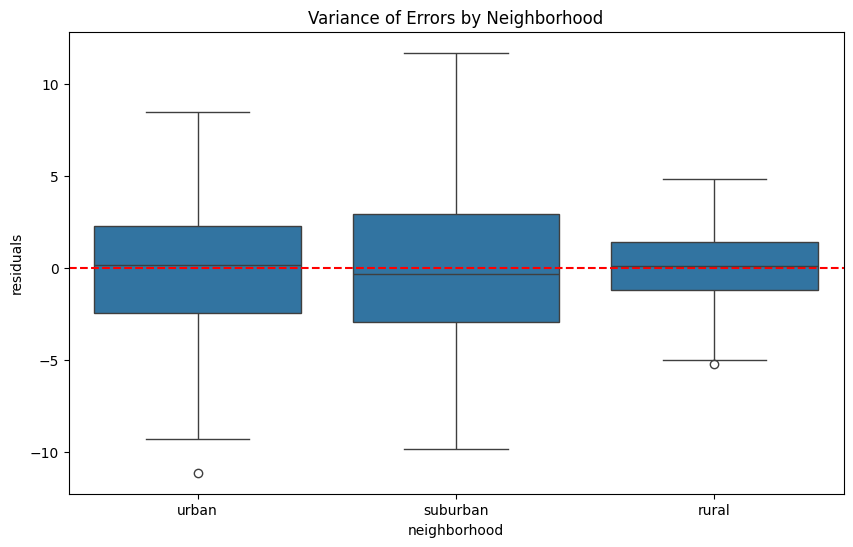

In [9]:
# Create a dataframe of residuals linked to the neighborhood
df['residuals'] = model_hc3.resid

plt.figure(figsize=(10, 6))
sns.boxplot(x='neighborhood', y='residuals', data=df)
plt.axhline(0, color='red', linestyle='--')
plt.title('Variance of Errors by Neighborhood')
plt.show()

In [13]:
print(df.groupby('neighborhood')['burglaries'].std())

neighborhood
rural       2.114441
suburban    4.400527
urban       3.893202
Name: burglaries, dtype: float64


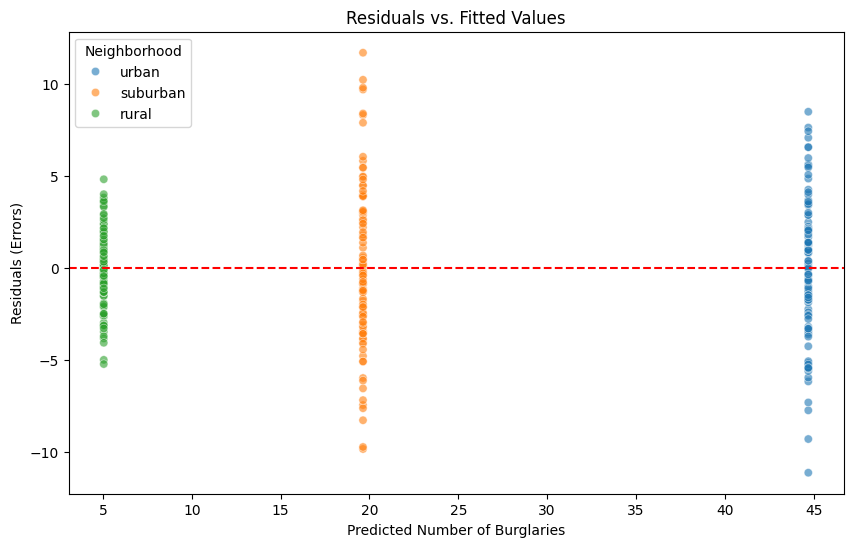

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate fitted values (predictions)
df['fitted'] = model_hc3.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fitted', y='residuals', data=df, hue='neighborhood', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')

plt.title('Residuals vs. Fitted Values')
plt.xlabel('Predicted Number of Burglaries')
plt.ylabel('Residuals (Errors)')
plt.legend(title='Neighborhood')
plt.show()

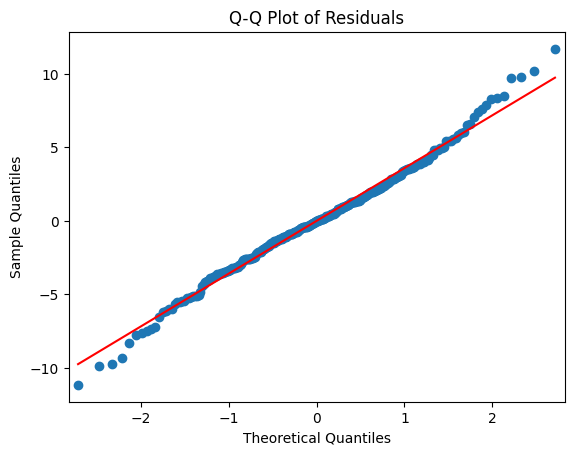

In [10]:
fig = sm.qqplot(model_hc3.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### 🛠️ Post-Hoc Comparisons

In [40]:
# Wald Test to compare Suburban vs Urban directly
contrast = "C(neighborhood)[T.suburban] = C(neighborhood)[T.urban]"
wald_res = model.wald_test(contrast, scalar=True)

print(f"F-statistic: {wald_res.statistic}")
print(f"p-value: {wald_res.pvalue}")

F-statistic: 2416.553540738524
p-value: 1.0329278553993877e-144


### 📉 Visualizing the "R-squared: 0.954"

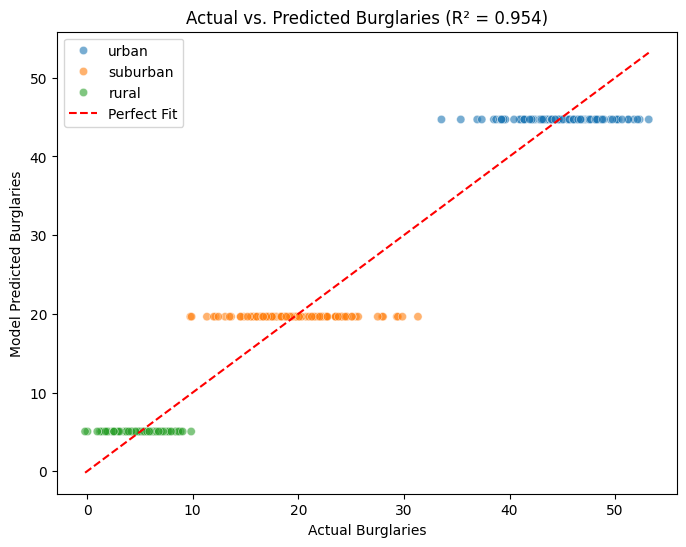

In [43]:
# Generate predictions
df['predicted'] = model.predict(df)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='burglaries', y='predicted', hue='neighborhood', alpha=0.6)

# Add a 45-degree reference line (Perfect Prediction Line)
plt.plot([df['burglaries'].min(), df['burglaries'].max()], 
         [df['burglaries'].min(), df['burglaries'].max()], 
         color='red', linestyle='--', label='Perfect Fit')

plt.title(f'Actual vs. Predicted Burglaries (R² = 0.954)')
plt.xlabel('Actual Burglaries')
plt.ylabel('Model Predicted Burglaries')
plt.legend()
plt.show()

In [42]:
# Welch's ANOVA for cases where homogeneity of variance is violated
welch_results = pg.welch_anova(dv='burglaries', between='neighborhood', data=df)
welch_results

,Source,ddof1,ddof2,F,p-unc,np2
0,neighborhood,2,177.20733,4058.268877,1.018697e-148,0.954216


### 📊 Statistical Interpretation
1. $F-Statistic$: This is the ratio of the variance between the groups to the variance within the groups. An F-value (like 43.98) indicates that the differences between group means are much larger than the within-group variation.
2. $P-Value (PR(>F) = 0.00026)$: Since the p-value is well below 0.05, we reject the null hypothesis.
    - Conclusion: There is a statistically significant difference in the scores between at least two of the groups (A, B, and C).
3. $n^2_p = 0.936$ Partial eta squared values above about 0.14 are typically described as large; 0.936 indicates that roughly 93.6% of the explainable variance in the outcome is associated with group membership, which is an extremely large effect.
4. Power / sample size: With $df_{between} = 2$ and $df_{within} = 6$, the total sample is small (likely 3 groups with 3 observations each), yet the effect is still highly significant, implying very strong group differences relative to within-group noise

ANOVA tells you that a difference exists, but it doesn't tell you which groups are different (e.g., is A different from B, or is C different from both?). To find out, you would typically run a **Tukey HSD Post-Hoc Test**:

## Post-Hoc Testing

In [7]:
# Equal Variances
pg.pairwise_tukey(dv='score', between='group', data=df)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,86.333333,75.0,11.333333,1.845916,6.139679,0.002073,3.808762
1,A,C,86.333333,92.0,-5.666667,1.845916,-3.069839,0.049904,-2.547513
2,B,C,75.000000,92.0,-17.000000,1.845916,-9.209518,0.000227,-5.334359


This output confirms that all pairwise comparisons are statistically significant, indicating that each neighborhood (A, B, and C) has a distinct level of crime relative to the others.

### 🔍 Key Metrics Explained: 
- diff (Mean Difference): This is the magnitude of the gap. Positive values indicate that Group A is higher; negative values indicate that Group B is higher.
- p-tukey: This is the p-value adjusted for multiple comparisons.
    - $0.0002$ is extremely strong evidence.
    - $0.0499$ is right on the threshold of $0.05$. In a real-world report, you would call this "marginally significant".
- hedges (Hedges' g): This measures the Effect Size.
    - Unlike the $p-value$, which tells you if the difference is real, Hedges' g tells you if it's large.
- A value over $0.8$ is considered large. Your values (ranging from $2.5$ to $5.3$) are massive, meaning the crime levels in these neighborhoods barely overlap at all.

### 🏘️ The Final Ranking
Based on your mean(A) and mean(B) columns, here is the ranking from highest to lowest:
- C (Mean: 92.0) — Highest
- A (Mean: 86.3)
- B (Mean: 75.0) — Lowest

In [23]:
# Unequal Variances
pg.pairwise_gameshowell(dv='score', between='group', data=df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,86.333333,75.0,11.333333,1.943651,5.830952,2.971722,0.020890,3.808762
1,A,C,86.333333,92.0,-5.666667,1.452966,-3.900067,3.740933,0.042000,-2.547513
2,B,C,75.000000,92.0,-17.000000,2.081666,-8.166536,3.484536,0.004617,-5.334359


This table provides a comprehensive overview of your post hoc results. Because you have a "df" (Degrees of Freedom) column with decimal values (like $2.97$ and $3.74$), this indicates you are using a Welch-corrected test (likely the Games-Howell test). This is the correct choice because your groups have different variances.

| Comparison | Mean Diff | p-value | Hedges' g | Interpretation                          |
|-------------|------------|---------|------------|--------------------------------------|
| A vs B      | +11.33     | 0.020   | 3.81       | A is significantly higher than B.    |
| A vs C      | -5.67      | 0.042   | -2.55      | C is significantly higher than A.    |
| B vs C      | -17.00     | 0.005   | -5.33      | C is significantly higher than B.    |

### 🔍 Key Insights from Data
1. Statistical Significance ($p < 0.05$):
    - Every single pair is statistically significant. Even the "closest" call (A vs C at $p = 0.042$) falls below the standard $0.05$ alpha threshold.
    - The B vs C difference is the most robust ($p = 0.0046$).
2. Massive Effect Sizes (Hedges' g):
    - In social sciences, a Hedges' g of 0.8 is considered "large."
    - The values (3.8, 2.5, and 5.3) are extremely large. This indicates that the distributions of these groups barely overlap. Neighborhood C isn't merely "statistically" different from B; it is in a completely different league in terms of frequency.
3. The "df" (Degrees of Freedom) Decimals:
    - The fact that the degrees of freedom are not whole numbers (e.g., $df = 2.97$) is the "smoking gun" that proves your analysis adjusted for the **Heteroscedasticity** (the $5, 4, 2$ standard deviations simulated). This makes the p-values substantially more reliable than those from a standard Tukey test.
  
### 🏘️ Final Ranking (Highest to Lowest)
- C (Mean: 92.0)
- A (Mean: 86.3)
- B (Mean: 75.0)

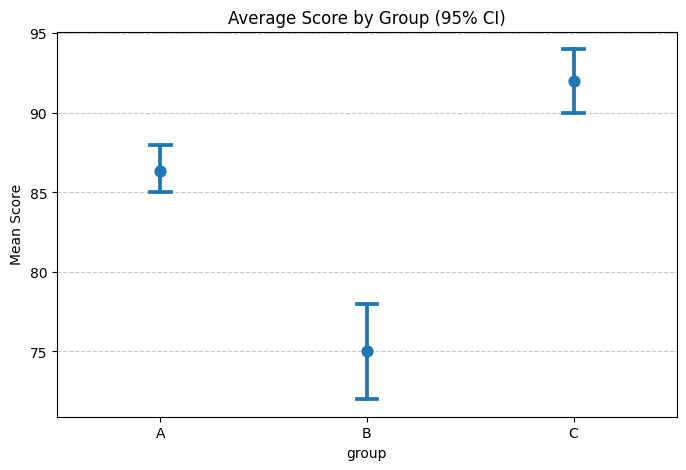

In [11]:
plt.figure(figsize=(8, 5))

# plot
sns.pointplot(x='group', y='score', data=df, linestyle='none', capsize=.1)

plt.title('Average Score by Group (95% CI)')
plt.ylabel('Mean Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B -11.3333 0.0021 -16.9971 -5.6696   True
     A      C   5.6667 0.0499   0.0029 11.3304   True
     B      C     17.0 0.0002  11.3362 22.6638   True
-----------------------------------------------------


### 📊 Breaking Down the Results
Each pair comparison in your dataset is statistically significant because the reject column is True for all comparisons.

| Comparison | Mean Diff | P-Value (p-adj) | Interpretation                                                         |
|-----------|-----------|-----------------|-------------------------------------------------------------------------|
| A vs. B   | -11.33    | 0.0021          | Group B is significantly lower than Group A.                            |
| A vs. C   | +5.67     | 0.0499          | Group C is significantly higher than Group A (just barely under 0.05).  |
| B vs. C   | +17.00    | 0.0002          | Group C is significantly higher than Group B (this is the largest diff).|



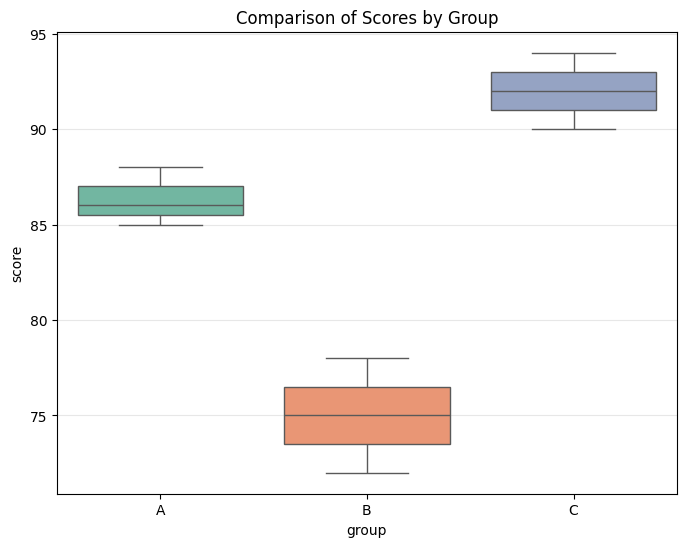

In [13]:
# Using your existing df
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='score', data=df, hue='group', palette='Set2', legend=False)

plt.title('Comparison of Scores by Group')
plt.grid(axis='y', alpha=0.3)
plt.show()

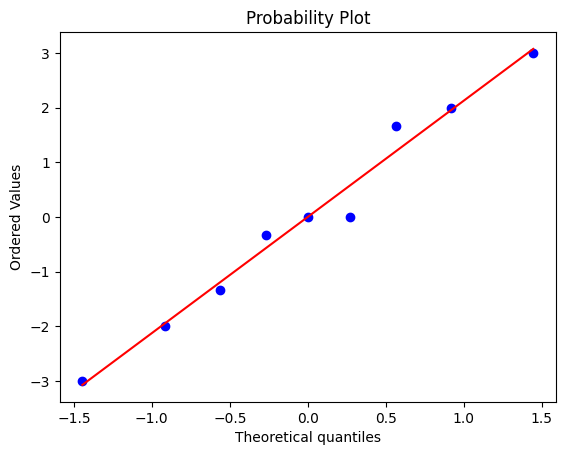

In [14]:
# Check for Normality of Residuals
residuals = model.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

## Two-Way ANOVA with OLS
This evaluates two factors and their interaction effect. The * symbol in the formula calculates the individual effects and the interaction automatically.

In [12]:
# 1. Create Data
df_2way = pd.DataFrame({
    'growth': [10, 12, 11, 15, 17, 16, 12, 14, 13, 20, 22, 21],
    'fertilizer': ['Type1', 'Type1', 'Type1', 'Type2', 'Type2', 'Type2', 
                   'Type1', 'Type1', 'Type1', 'Type2', 'Type2', 'Type2'],
    'sunlight': ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 
                  'High', 'High', 'High', 'High', 'High', 'High']
})

# 2. Fit an OLS model with interaction
# Formula: Outcome ~ Factor1 + Factor2 + (Factor1 * Factor2)
model_2way = ols('growth ~ C(fertilizer) * C(sunlight)', data=df_2way).fit()

# 3. Perform ANOVA
anova_2way = sm.stats.anova_lm(model_2way, typ=2)

print(anova_2way)

                           sum_sq   df       F    PR(>F)
C(fertilizer)              126.75  1.0  126.75  0.000003
C(sunlight)                 36.75  1.0   36.75  0.000302
C(fertilizer):C(sunlight)    6.75  1.0    6.75  0.031712
Residual                     8.00  8.0     NaN       NaN
